<a href="https://colab.research.google.com/github/Ben-Najafloo/Fairness-evaluation/blob/main/fairlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fairlearn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_diabetes_hospital
data = fetch_diabetes_hospital(as_frame=True)



,count
race,
Caucasian,76099
AfricanAmerican,19210
Unknown,2273
Hispanic,2037
Other,1506
Asian,641


In [8]:
X = data.data.copy()
X.drop(columns=["readmitted", "readmit_binary"], inplace=True)
y = data.target
X_ohe = pd.get_dummies(X)
race = X['race']
race.value_counts()


,count
race,
Caucasian,76099
AfricanAmerican,19210
Unknown,2273
Hispanic,2037
Other,1506
Asian,641


In [9]:
data.data.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
0,Caucasian,Female,'30 years or younger',Other,Referral,1,Other,41,0,1,...,No,No,No,False,False,False,False,False,NO,0
1,Caucasian,Female,'30 years or younger','Discharged to Home',Emergency,3,Missing,59,0,18,...,Up,Ch,Yes,False,False,False,False,False,>30,1
2,AfricanAmerican,Female,'30 years or younger','Discharged to Home',Emergency,2,Missing,11,5,13,...,No,No,Yes,False,False,False,True,True,NO,0
3,Caucasian,Male,'30-60 years','Discharged to Home',Emergency,2,Missing,44,1,16,...,Up,Ch,Yes,False,False,False,False,False,NO,0
4,Caucasian,Male,'30-60 years','Discharged to Home',Emergency,1,Missing,51,0,8,...,Steady,Ch,Yes,False,False,False,False,False,NO,0


In [14]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score # Importing precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from fairlearn.metrics import false_positive_rate, false_negative_rate, selection_rate, count
np.random.seed(42)  # set seed for consistent results
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X_ohe, y, race, random_state=123)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X_train, y_train)
# DecisionTreeClassifier(...)
y_pred = (classifier.predict_proba(X_test)[:,1] >= 0.1)
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
mf.overall.item()

mf.by_group

,accuracy_score
race,
AfricanAmerican,0.530935
Asian,0.658683
Caucasian,0.503535
Hispanic,0.612524
Other,0.591549
Unknown,0.574576


In [12]:
from fairlearn.metrics import false_negative_rate
mf = MetricFrame(metrics=false_negative_rate, y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
mf.overall.item()

mf.by_group

,false_negative_rate
race,
AfricanAmerican,0.296089
Asian,0.500000
Caucasian,0.308555
Hispanic,0.307692
Other,0.333333
Unknown,0.420000


array([[<Axes: title={'center': 'accuracy'}, xlabel='race'>,
        <Axes: title={'center': 'precision'}, xlabel='race'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='race'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='race'>,
        <Axes: title={'center': 'selection rate'}, xlabel='race'>,
        <Axes: title={'center': 'count'}, xlabel='race'>],
       [<Axes: xlabel='race'>, <Axes: xlabel='race'>,
        <Axes: xlabel='race'>]], dtype=object)

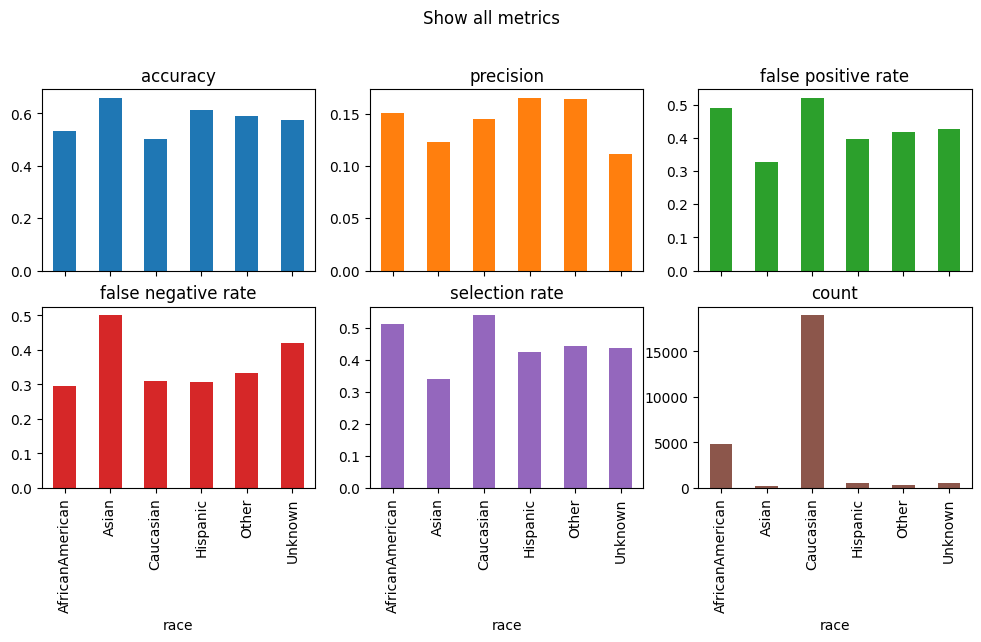

In [15]:
np.random.seed(42)  # set seed for consistent results
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X_ohe, y, race, random_state=123)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X_train, y_train)
# DecisionTreeClassifier(...)
y_pred = (classifier.predict_proba(X_test)[:,1] >= 0.1)
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
mf.overall.item()

mf.by_group

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score, # Using precision_score instead of zero_div_precision_score
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=A_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [16]:
from fairlearn.reductions import ErrorRate, EqualizedOdds, ExponentiatedGradient
objective = ErrorRate(costs={'fp': 0.1, 'fn': 0.9})
constraint = EqualizedOdds(difference_bound=0.01)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint, objective=objective)
mitigator.fit(X_train, y_train, sensitive_features=A_train)

y_pred_mitigated = mitigator.predict(X_test)
mf_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test)
mf_mitigated.overall.item()

mf_mitigated.by_group

,accuracy_score
race,
AfricanAmerican,0.524358
Asian,0.562874
Caucasian,0.525588
Hispanic,0.549902
Other,0.478873
Unknown,0.511864


In [17]:
mf.by_group

,accuracy_score
race,
AfricanAmerican,0.530935
Asian,0.658683
Caucasian,0.503535
Hispanic,0.612524
Other,0.591549
Unknown,0.574576
